# Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# # Where to save the figures
# PROJECT_ROOT_DIR = "."
# CHAPTER_ID = "ann"
# IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
# os.makedirs(IMAGES_PATH, exist_ok=True)

# def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
#     path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
#     print("Saving figure", fig_id)
#     if tight_layout:
#         plt.tight_layout()
#     plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Perceptrons
- The **Perceptron** is one of the simplest Artificial Neural Network architectures.
- A Perceptron is simply composed of a single layer of **Threshold Logic Units (TLUs)**, with each TLU connected to all the inputs.
    - For a threshold logic unit (TLU), or sometimes a linear threshold unit (LTU), the inputs and output are now numbers (instead of binary on/off values) and each input connection is associated with a weight. 
    - The TLU computes a **weighted sum of its inputs** (i.e. $z = X^{T}W$), then applies a **step function** to that sum and outputs the result: $h_w(X) = step(z)$, where $z = X^{T}W$.
- When all the neurons in a layer are connected to every neuron in the previous layer (i.e., its input neurons), it is called a **fully connected layer** or a **dense layer**.
- To represent the fact that each input is sent to every TLU, it is common to draw special passthrough neurons called **input neurons**: they just output whatever input they are fed. 
    - All the input neurons form the **input layer**.
- Moreover, an extra bias feature is generally added ($X_0$ = 1): it is typically represented using a special type of neuron called a **bias neuron**, which just outputs 1 all the time.
- It is possible to efficiently compute the outputs of a layer of artificial neurons for several instances at once:
    - $h_{W,b}(X) = \Phi(XW+b)$
    - The function $\phi$ is called the **activation function**: when the artificial neurons are TLUs, it is a step function.
    
## How is a Perceptron trained?
- The Perceptron is fed one training instance at a time, and for each instance it makes its predictions. 
- For every output neuron that produced a wrong prediction, it reinforces the connection weights from the inputs that would have contributed to the correct prediction.
- Perceptron learning rule (weight update):
    - $w_{i,j}^{(next \: step)} = w_{i,j} + \eta(y_i - \hat{y}_i)x_i$
        - $w_{i,j}$ is the connection weight between the ith input neuron and the jth output neuron.
        - $x_i$ is the $i^{th}$ input value of the current training instance.
        - $\hat{y}_j$ is the output of the $j^{th}$ output neuron for the current training instance.
        - $y_j$ is the target output of the $j^{th}$ output neuron for the current training instance.
        - $\eta$ is the **learning rate**.

In [2]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris()
X = iris.data[:, (2,3)]
y = (iris.target == 0).astype(np.int)

per_clf = Perceptron(max_iter=1000, tol=1e-3, random_state=42)
per_clf.fit(X, y)

y_pred = per_clf.predict([[2, 0.5]])

In [3]:
y_pred

array([1])

# Multi-Layer Perceptron and Backpropagation
- An **Multi-Layer Perceptron (MLP)** is composed of one (passthrough) **input layer**, one or more layers of TLUs, called **hidden layers**, and one final layer of TLUs called the **output layer**. 
    - The layers close to the input layer are usually called the lower layers, and the ones close to the outputs are usually called the upper layers. 
    - Every layer except the output layer includes a bias neuron and is fully connected to the next layer.
- When an ANN contains a deep stack of hidden layers, it is called a **deep neural network (DNN)**.
- The **Backpropagation** Training Algorithm
    - For each training instance, the backpropagation algorithm first makes a prediction (**forward pass**), measures the error, then goes through each layer in reverse to measure the error contribution from each connection (**reverse pass**), and finally slightly tweaks the connection weights to reduce the error (**Gradient Descent step**).

## The Backpropagation Algorithm
*A Summary from Udemy Python for Data Science and Machine Learning Bootcamp*
- Notations:
    - $X$: input (vector of features)
    - $y$: target output
    - $L$: total number of layers
    - $\sigma$: activation function
    - $C$: cost function
    - $W^{l} = (w^{l}_{jk})$: the weights between layer $l-1$ and layer $l$
- Step 1 - Pass the input $X$ to the input layer and apply the activation function $\sigma$ to get a result $a$:
    - $z = WX + b$
    - $a = \sigma(z)$
    - This resulting $a$ is then fed into the next layer as the new $X$ (and so on).
- Step 2 - For each layer, compute:
    - $z^{l} = W^{l}a^{l-1} + b^{l}$
    - $a^{l} = \sigma(z^{l})$
- Step 3 - Compute the error vector:
    - $\delta^{L} = \nabla_aC \circ \sigma'(z^{L})$
        - $\nabla_aC$ = the rate of change of cost function $C$ with respect to the output activations $a^{L}$
        - Operator $\circ$ = Hadamard Product, i.e. element-to-element multiplication
- Step 4 - Backpropagate the error: 
    - For each layer $l = L-1, L-2, ...$:
        - $\delta^{l} = (W^{l+1})^{T}\delta^{l+1} \circ \sigma'(z^{l})$
- Step 5 - Adjust the weight $W^{l}$ and bias $b^{l}$ for each layer through gradient descent:
    - $\frac{\partial C}{\partial w^{l}_jk} =a^{l-1}_k \delta^{l}_j$
        - $w^{l}_{jk}$ is the weight between the $k^{th}$ node on layer $l-1$ and the $j^{th}$ node on layer $l$.
    - $\frac{\partial C}{\partial b^{l}_j} = \delta^{l}_j$

### About Activation Functions
- In order to make the algorithm work properly, people have also been **changing the activation function** from the step function to some other alternatives.
    - This was essential because the step function contains only flat segments, so there is no gradient to work with (Gradient Descent cannot move on a flat surface).
    - We need activation functions with well-defined nonzero derivatives everywhere, allowing Gradient Descent to make some progress at every step.
    - Commonly used activation functions are: 
        - The **logistic (sigmoid) function**: 
            - $\sigma(z) = 1/(1+exp(-z))$
        - The **hyperbolic tangent function**: 
            - $tanh(z) = 2\sigma(2z)-1$
        - The **Rectified Linear Unit function (ReLu)**: 
            - $ReLU(z) = max(0, z)$
    - For more activation functions, check out:
        - https://en.wikipedia.org/wiki/Activation_function

In [4]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps)) / (2 * eps)

[-5, 5, -0.2, 1.2]

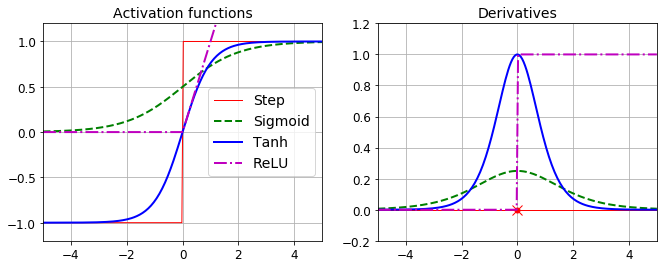

In [5]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(z, np.sign(z), "r-", linewidth=1, label="Step")
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=1, label="Step")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=2, label="Tanh")
plt.plot(z, derivative(relu, z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
#plt.legend(loc="center right", fontsize=14)
plt.title("Derivatives", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

# Multi-Class Classification Considerations
*A Summary from Udemy Python for Data Science and Machine Learning Bootcamp*
- Note that all the activation functions introduced above would make sense for a single output, either a continuous prediction or a binary label.
    - Correspondingly, it seems like we always assumed that there is only one node in the output layer.
- For a **multi-class classification** problem, we may need something different.
    - The easies way to handle this problem is have **one neuron for each class** on the output layer.
    - We also need to re-organize our training data using **One-Hot Encoding**.
- Activation Functions
    - **Non-Exclusive** Classes
        - **Sigmoid Function**: $\frac{1}{1+e^{-z}}$
            - Each neuron will output a value between 0 and 1, indicating the probability of having that class assigned to it.
            
    - **Mutually-Exclusive** Classes
        - **Softmax Function**: $\sigma(z)_i = \frac{e^{z_i}}{\sum_{j=1}^{K}e^{z_j}}$, $i=1,2,...K$, where $K$ is the total number of classes.
            - The softmax function will calculate the probability of each class over all possible classes.
            - More specifically, the $i^{th}$ neuron will calculate the probability of assigining the $i^{th}$ class to the instance.
            - Thus, each neuron will output a value between 0 and 1, all adding up to 1.

# Building an Image Classifier

- First, import TensorFlow and Keras.

In [6]:
import tensorflow as tf
from tensorflow import keras

In [7]:
tf.__version__

'2.0.0'

In [8]:
keras.__version__

'2.2.4-tf'

- Load the fashion MNIST dataset.

In [9]:
fashion_mnist = keras.datasets.fashion_mnist

(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

In [10]:
X_train_full.shape

(60000, 28, 28)

In [11]:
X_train_full.dtype

dtype('uint8')

- Let's split the full training set into a validation set and a smaller training set.
- We also scale the pixel intensities down to the 0-1 range and convert them to floats by diviting 255.

In [12]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

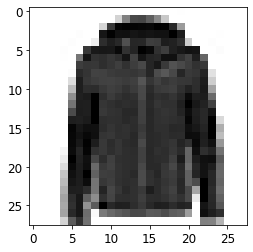

In [13]:
plt.imshow(X_train[0], cmap='binary')

- Here are the labels and correponding class names (obtained manually).

In [14]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

In [15]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

class_names[y_train[0]]

'Coat'

- Let's look at a sample of the images in the dataset.

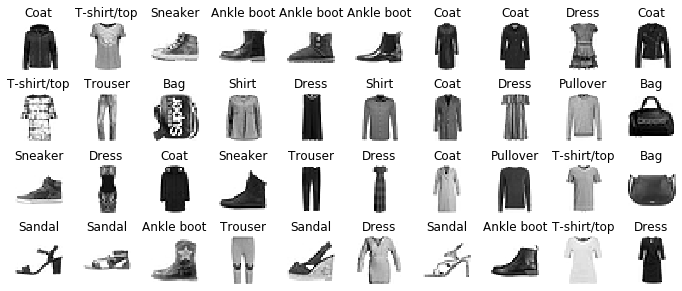

In [16]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))

for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols*row + col
        plt.subplot(n_rows, n_cols, index+1)
        plt.imshow(X_train[index], cmap='binary', interpolation='nearest')
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
        
plt.subplots_adjust(wspace=0.2, hspace=0.5)

- Creating the model using the `Squential` API.
- Let’s go through the code below line by line:
    - The first line creates a **Sequential model**. 
        - This is the simplest kind of Keras model, for neural networks that are just composed of a single stack of layers, connected sequentially. This is called the sequential API.
    - Next, we build the first layer and add it to the model. 
        - It is a **Flatten layer** whose role is simply to **convert each input image into a 1D array**: if it receives input data X, it computes X.reshape(-1, 1). 
        - This layer does not have any parameters, it is just there to do some simple preprocessing. 
        - Since it is the first layer in the model, you should specify the `input_shape`: this does not include the batch size, only the shape of the instances. 
        - Alternatively, you could add a `keras.layers.InputLayer` as the first layer, `setting shape=[28,28]`.
    - Next we add a **Dense hidden layer** with 300 neurons. 
        - It will use the ReLU activation function. 
        - Each Dense layer manages its own weight matrix, containing all the connection weights between the neurons and their inputs. It also manages a vector of bias terms (one per neuron). 
        - When it receives some input data, it computes $h_{W,b}(X) = \Phi(XW+b)$.
    - Next we add a second Dense hidden layer with 100 neurons, also using the ReLU activation function.
    - Finally, we add a **Dense output layer** with 10 neurons (one per class), using the softmax activation function (because the classes are exclusive).

In [17]:
model = keras.models.Sequential()

model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation='relu'))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))

In [18]:
model.layers

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


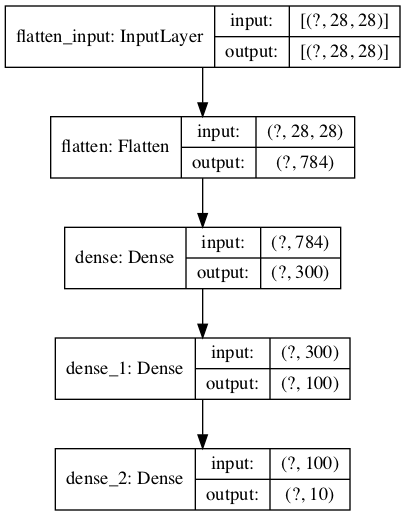

In [20]:
keras.utils.plot_model(model, "my_fasion_mnist_model.png", show_shapes=True)

In [21]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [22]:
model.get_layer(hidden1.name) is hidden1

True

- All the parameters of a layer can be accessed using its `get_weights()` and `set_weights()` method.

In [23]:
weights, biases = hidden1.get_weights()

In [24]:
weights

array([[ 0.04515666, -0.069977  ,  0.06051429, ...,  0.04753841,
        -0.04744945,  0.0120912 ],
       [ 0.04659864, -0.04578223,  0.07400607, ..., -0.05066   ,
        -0.0084181 , -0.03304876],
       [ 0.06414753, -0.03600916,  0.05302051, ..., -0.01792533,
         0.06207846,  0.03128438],
       ...,
       [-0.00251668,  0.05214743, -0.0117376 , ..., -0.02881119,
        -0.07110146,  0.03284575],
       [ 0.05465785, -0.01079703, -0.00169583, ...,  0.03523929,
         0.04061551, -0.04402542],
       [ 0.00068085,  0.06616262, -0.054733  , ...,  0.05206339,
        -0.02470464,  0.03530402]], dtype=float32)

In [25]:
weights.shape

(784, 300)

- Notice that the Dense layer initialized the connection weights randomly (which is needed to break symmetry, as we discussed earlier), and the biases were just initialized to zeros, which is fine.

In [26]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [27]:
biases.shape

(300,)

- After a model is created, you must call its `compile()` method to specify the loss function and the optimizer to use.
    - First, we use the **"sparse_categorical_crossentropy" loss** because we have sparse labels (i.e., for each instance there is just a target class index, from 0 to 9 in this case), and the classes are exclusive. 
        - If instead we had **one target probability per class** for each instance (such as one-hot vectors, e.g. [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.] to represent class 3), then we would need to use the **"categorical_crossentropy"** loss instead. 
        - If we were doing **binary classification** (with one or more binary labels), then we would use the **"sigmoid"** (i.e., logistic) activation function in the output layer instead of the "softmax" activation function, and we would use the **"binary_crossentropy"** loss.
    - Secondly, regarding the optimizer, "sgd" simply means that we will train the model using simple **Stochastic Gradient Descent**.
    - Finally, since this is a classifier, it’s useful to measure its "accuracy" during training and evaluation.

In [28]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [29]:
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/30
55000/55000 [==============================] - 6s 116us/sample - loss: 0.7099 - accuracy: 0.7657 - val_loss: 0.5275 - val_accuracy: 0.8220
Epoch 2/30
55000/55000 [==============================] - 6s 116us/sample - loss: 0.4871 - accuracy: 0.8300 - val_loss: 0.4448 - val_accuracy: 0.8464
Epoch 3/30
55000/55000 [==============================] - 6s 111us/sample - loss: 0.4429 - accuracy: 0.8441 - val_loss: 0.4280 - val_accuracy: 0.8540
Epoch 4/30
55000/55000 [==============================] - 6s 112us/sample - loss: 0.4163 - accuracy: 0.8545 - val_loss: 0.4187 - val_accuracy: 0.8564
Epoch 5/30
55000/55000 [==============================] - 6s 114us/sample - loss: 0.3960 - accuracy: 0.8623 - val_loss: 0.3792 - val_accuracy: 0.8684
Epoch 6/30
55000/55000 [==============================] - 6s 112us/sample - loss: 0.3796 - accuracy: 0.8662 - val_loss: 0.3872 - val_accuracy: 0.8626
Epoch 7/30
55000/55000 [===========================

In [30]:
history.params

{'batch_size': 32,
 'epochs': 30,
 'steps': 1719,
 'samples': 55000,
 'verbose': 0,
 'do_validation': True,
 'metrics': ['loss', 'accuracy', 'val_loss', 'val_accuracy']}

In [31]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


(0, 1)

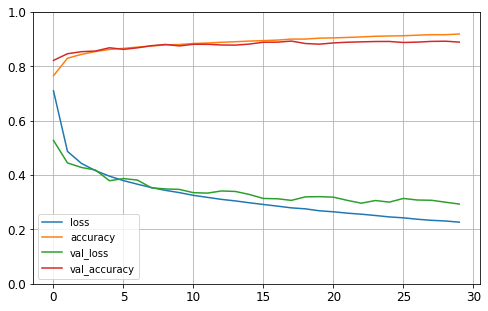

In [32]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)

In [33]:
model.evaluate(X_test, y_test, verbose=0)

[0.32636287940144537, 0.8829]

In [34]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.98],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [35]:
y_pred = model.predict_classes(X_new)
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

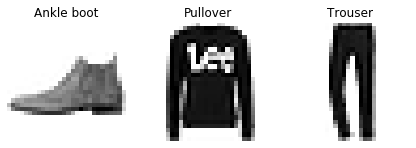

In [36]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)

# Regression MLP
- Building, training, evaluating and using a regression MLP using the Sequential API to make predictions is quite similar to what we did for classification. 
    - The main differences are the fact that the **output layer** has **a single neuron** (since we only want to predict a single value) and uses **no activation function**, and the loss function is the **mean squared error**.
- Let's load, sploit, and scale the California Housing dataset.

In [37]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.fit_transform(X_valid)
X_test = scaler.fit_transform(X_test)

In [38]:
np.random.seed(42)
tf.random.set_seed(42)

In [39]:
model = keras.Sequential([
    keras.layers.Dense(30, activation='relu', input_shape=X_train[0].shape),
    keras.layers.Dense(1)
])

model.compile(loss='mean_squared_error', optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/30
11610/11610 [==============================] - 1s 82us/sample - loss: 1.6321 - val_loss: 0.8146
Epoch 2/30
11610/11610 [==============================] - 1s 46us/sample - loss: 0.7124 - val_loss: 0.6724
Epoch 3/30
11610/11610 [==============================] - 1s 47us/sample - loss: 0.6348 - val_loss: 0.6268
Epoch 4/30
11610/11610 [==============================] - 1s 47us/sample - loss: 0.5983 - val_loss: 0.5935
Epoch 5/30
11610/11610 [==============================] - 1s 47us/sample - loss: 0.5713 - val_loss: 0.5720
Epoch 6/30
11610/11610 [==============================] - 1s 46us/sample - loss: 0.5482 - val_loss: 0.5535
Epoch 7/30
11610/11610 [==============================] - 1s 46us/sample - loss: 0.5298 - val_loss: 0.5394
Epoch 8/30
11610/11610 [==============================] - 1s 46us/sample - loss: 0.5138 - val_loss: 0.5249
Epoch 9/30
11610/11610 [==============================] - 1s 46us/sample - loss: 0.5005 - val_l

In [40]:
model.evaluate(X_test, y_test, verbose=0)

0.40478352220483527

In [41]:
X_new = X_test[:3]
y_pred = model.predict(X_new)
y_pred, y_test[:3]

(array([[0.34051526],
        [1.8398935 ],
        [3.565778  ]], dtype=float32),
 array([0.477  , 0.458  , 5.00001]))

(0, 1)

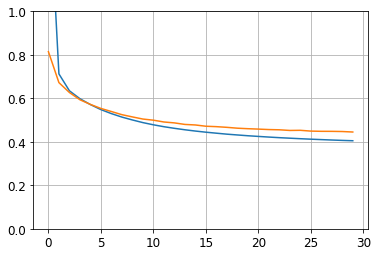

In [42]:
plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.gca().set_ylim(0, 1)

# Functional API
- Not all neural network models are simply sequential.
- One example of a non-sequential neural network is a **Wide & Deep neural network**.
    - It connects **all or part of the inputs directly to the output layer**.
    - This architecture makes it possible for the neural network to learn **both deep patterns (using the deep path) and simple rules (through the short path)**. 
    - In contrast, a regular MLP forces all the data to flow through the full stack of layers, thus simple patterns in the data may end up being distorted by this sequence of transformations.

In [43]:
np.random.seed(42)
tf.random.set_seed(42)

- First, we need to create an **Input object**.
    - This is needed because we may have multiple inputs, as we will see later.
- Next, we create a **Dense layer** with 30 neurons and using the ReLU activation function. 
    - As soon as it is created, notice that we **call it like a function**, passing it the input. 
    - This is why this is called the **Functional API**.
- We then create a second hidden layer, and again we use it as a function. 
    - Note however that we pass it the output of the first hidden layer.
- Next, we create a **concatenate() layer**, and once again we immediately use it like a function, to **concatenate the input and the output of the second hidden layer**.
- Then we create the **output layer**, with a single neuron and no activation function, and we call it like a function, passing it the result of the concatenation.
- Lastly, we create a Keras Model, specifying which inputs and outputs to use.

In [44]:
input_ = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation='relu')(input_)
hidden2 = keras.layers.Dense(30, activation='relu')(hidden1)
concat = keras.layers.concatenate([input_, hidden2])
output = keras.layers.Dense(1)(concat)

model = keras.models.Model(inputs=[input_], outputs=[output])

In [45]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 30)           270         input_1[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 30)           930         dense_5[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 38)           0           input_1[0][0]                    
                                                                 dense_6[0][0]                

In [46]:
model.compile(loss='mean_squared_error', optimizer=keras.optimizers.SGD(lr=1e-3))

history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/30
11610/11610 [==============================] - 1s 108us/sample - loss: 1.2474 - val_loss: 0.6968
Epoch 2/30
11610/11610 [==============================] - 1s 56us/sample - loss: 0.6341 - val_loss: 0.6358
Epoch 3/30
11610/11610 [==============================] - 1s 56us/sample - loss: 0.5885 - val_loss: 0.5949
Epoch 4/30
11610/11610 [==============================] - 1s 56us/sample - loss: 0.5599 - val_loss: 0.5703
Epoch 5/30
11610/11610 [==============================] - 1s 57us/sample - loss: 0.5367 - val_loss: 0.5532
Epoch 6/30
11610/11610 [==============================] - 1s 57us/sample - loss: 0.5170 - val_loss: 0.5344
Epoch 7/30
11610/11610 [==============================] - 1s 57us/sample - loss: 0.5022 - val_loss: 0.5236
Epoch 8/30
11610/11610 [==============================] - 1s 57us/sample - loss: 0.4885 - val_loss: 0.5099
Epoch 9/30
11610/11610 [==============================] - 1s 57us/sample - loss: 0.4778 - val_

In [47]:
mse_test = model.evaluate(X_test, y_test, verbose=0)
mse_test

0.3923840394777845

- What if we want to send different subsets of input features through the wide or deep paths?
    - We will send 5 features (features 0 to 4) through the wide path, and 6 features (features 2 to 7) through the deep path.
    - Note that 3 features (features 2, 3, 4) will go through both.

In [48]:
np.random.seed(42)
tf.random.set_seed(42)

In [49]:
input_A = keras.layers.Input(shape=[5], name='wide_input')
input_B = keras.layers.Input(shape=[6], name='deep_input')
hidden1 = keras.layers.Dense(30, activation='relu')(input_B)
hidden2 = keras.layers.Dense(30, activation='relu')(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name='output')(concat)
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

In [50]:
model.compile(loss='mse', optimizer=keras.optimizers.SGD(lr=1e-3))

In [51]:
X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

In [52]:
history = model.fit((X_train_A, X_train_B), y_train, epochs=20, validation_data=((X_valid_A, X_valid_B), y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 1s 99us/sample - loss: 1.8095 - val_loss: 0.8101
Epoch 2/20
11610/11610 [==============================] - 1s 59us/sample - loss: 0.6798 - val_loss: 0.6453
Epoch 3/20
11610/11610 [==============================] - 1s 58us/sample - loss: 0.5957 - val_loss: 0.5978
Epoch 4/20
11610/11610 [==============================] - 1s 56us/sample - loss: 0.5580 - val_loss: 0.5669
Epoch 5/20
11610/11610 [==============================] - 1s 57us/sample - loss: 0.5331 - val_loss: 0.5504
Epoch 6/20
11610/11610 [==============================] - 1s 57us/sample - loss: 0.5124 - val_loss: 0.5346
Epoch 7/20
11610/11610 [==============================] - 1s 56us/sample - loss: 0.4972 - val_loss: 0.5254
Epoch 8/20
11610/11610 [==============================] - 1s 60us/sample - loss: 0.4834 - val_loss: 0.5157
Epoch 9/20
11610/11610 [==============================] - 1s 57us/sample - loss: 0.4746 - val_l

In [53]:
model.evaluate((X_test_A, X_test_B), y_test, verbose=0)

0.43282527868137805

- Adding an **auxiliary output** for regularization
    - You may want to add some auxiliary outputs in a neural network architecture to ensure that the underlying part of the network learns something useful on its own, without relying on the rest of the network.
- In the code below, we'll add an auxiliary output layer to hidden layer 2, which will show the power of the depth path only.

In [54]:
input_A = keras.layers.Input(shape=[5], name='wide_input')
input_B = keras.layers.Input(shape=[6], name='deep_input')
hidden1 = keras.layers.Dense(30, activation='relu')(input_B)
hidden2 = keras.layers.Dense(30, activation='relu')(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name='main_output')(concat)
aux_output = keras.layers.Dense(1, name='aux_output')(hidden2)

model = keras.models.Model(inputs=[input_A, input_B], outputs=[output, aux_output])

In [55]:
model.compile(loss=['mse', 'mse'], loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(lr=1e-3))

In [56]:
# Note: since here we have two parallel output layers, when fitting the model, 
# we need to specify two response variabels (identical here), i.e. [y_train, y_train] 
history = model.fit([X_train_A, X_train_B], [y_train, y_train], epochs=20, 
                    validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid]))

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 2s 147us/sample - loss: 2.0913 - main_output_loss: 1.8435 - aux_output_loss: 4.3144 - val_loss: 1.0987 - val_main_output_loss: 0.8657 - val_aux_output_loss: 3.1942
Epoch 2/20
11610/11610 [==============================] - 1s 66us/sample - loss: 0.9790 - main_output_loss: 0.7783 - aux_output_loss: 2.7838 - val_loss: 0.8586 - val_main_output_loss: 0.7049 - val_aux_output_loss: 2.2404
Epoch 3/20
11610/11610 [==============================] - 1s 66us/sample - loss: 0.8065 - main_output_loss: 0.6677 - aux_output_loss: 2.0549 - val_loss: 0.7512 - val_main_output_loss: 0.6377 - val_aux_output_loss: 1.7705
Epoch 4/20
11610/11610 [==============================] - 1s 67us/sample - loss: 0.7200 - main_output_loss: 0.6113 - aux_output_loss: 1.6969 - val_loss: 0.6929 - val_main_output_loss: 0.5968 - val_aux_output_loss: 1.5567
Epoch 5/20
11610/11610 [==============================] - 1s 66us/

In [57]:
total_loss, main_loss, aux_loss = model.evaluate([X_test_A, X_test_B], [y_test, y_test], verbose=0)

# The Subclassing API
- Some models involve loops, varying shapes, conditional branching, and other dynamic behaviors.
- For such cases, we can use the Subclassing API.
- To do this, we simply **subclass the Model class**, **create the layers** you need in the constructor, and use them to perform the computations you want in the `call()` method. 
- For example, creating an instance of the following `WideAndDeepModel` class gives us an **equivalent model** to the one we just built with the Functional API.

In [58]:
class WideAndDeepModel (keras.models.Model):
    def __init__(self, units=30, activation='relu', **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(units, activation=activation)
        self.hidden2 = keras.layers.Dense(units, activation=activation)
        self.main_output = keras.layers.Dense(1)
        self.aux_output = keras.layers.Dense(1)
        
    def call(self, inputs):
        inputA, inputB = inputs
        hidden1 = self.hidden1(inputB)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([inputA, hidden2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return main_output, aux_output

In [59]:
model = WideAndDeepModel(30, activation="relu")

In [60]:
model.compile(loss="mse", loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit((X_train_A, X_train_B), (y_train, y_train), epochs=10,
                    validation_data=((X_valid_A, X_valid_B), (y_valid, y_valid)))
total_loss, main_loss, aux_loss = model.evaluate((X_test_A, X_test_B), (y_test, y_test), verbose=0)

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 2s 150us/sample - loss: 2.5145 - output_1_loss: 2.3428 - output_2_loss: 4.0508 - val_loss: 1.1630 - val_output_1_loss: 0.9863 - val_output_2_loss: 2.7523
Epoch 2/10
11610/11610 [==============================] - 1s 66us/sample - loss: 0.9865 - output_1_loss: 0.8287 - output_2_loss: 2.4063 - val_loss: 0.8506 - val_output_1_loss: 0.7308 - val_output_2_loss: 1.9273
Epoch 3/10
11610/11610 [==============================] - 1s 66us/sample - loss: 0.7828 - output_1_loss: 0.6701 - output_2_loss: 1.7954 - val_loss: 0.7448 - val_output_1_loss: 0.6552 - val_output_2_loss: 1.5495
Epoch 4/10
11610/11610 [==============================] - 1s 67us/sample - loss: 0.6916 - output_1_loss: 0.6026 - output_2_loss: 1.4923 - val_loss: 0.6858 - val_output_1_loss: 0.6101 - val_output_2_loss: 1.3661
Epoch 5/10
11610/11610 [==============================] - 1s 66us/sample - loss: 0.6362 - output_1_loss: 0

In [61]:
model.layers

In [62]:
model.summary()

Model: "wide_and_deep_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             multiple                  210       
_________________________________________________________________
dense_13 (Dense)             multiple                  930       
_________________________________________________________________
dense_14 (Dense)             multiple                  36        
_________________________________________________________________
dense_15 (Dense)             multiple                  31        
Total params: 1,207
Trainable params: 1,207
Non-trainable params: 0
_________________________________________________________________


- From above, we can see that the big difference between using Subclassing and Functional API is that you can do pretty much anything you want in the `call()` method here: for loops, if statements, low-level TensorFlow operations, etc.
    - This makes it a great API for researchers experimenting with new ideas.
- However, this extra flexibility comes at a cost: your model’s architecture is hidden within the `call()` method, so Keras cannot easily inspect it, it cannot save or clone it, and when you call the `summary()` method, you only get a list of layers, without any information on how they are connected to each other. 
- Moreover, Keras cannot check types and shapes ahead of time, and it is easier to make mistakes. So unless you really need that extra flexibility, you should probably **stick to the Sequential API or the Functional API**.

# Saving and Restoring Models

In [63]:
np.random.seed(42)
tf.random.set_seed(42)

In [64]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation='relu', input_shape=[8]),
    keras.layers.Dense(30, activation='relu'),
    keras.layers.Dense(1)
])

In [65]:
model.compile(optimizer=keras.optimizers.SGD(lr=1e-3), loss='mse')

In [66]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 1s 89us/sample - loss: 1.8631 - val_loss: 0.7804
Epoch 2/10
11610/11610 [==============================] - 1s 49us/sample - loss: 0.6723 - val_loss: 0.6186
Epoch 3/10
11610/11610 [==============================] - 1s 49us/sample - loss: 0.5927 - val_loss: 0.5829
Epoch 4/10
11610/11610 [==============================] - 1s 49us/sample - loss: 0.5550 - val_loss: 0.5511
Epoch 5/10
11610/11610 [==============================] - 1s 49us/sample - loss: 0.5278 - val_loss: 0.5357
Epoch 6/10
11610/11610 [==============================] - 1s 49us/sample - loss: 0.5032 - val_loss: 0.5102
Epoch 7/10
11610/11610 [==============================] - 1s 49us/sample - loss: 0.4863 - val_loss: 0.5011
Epoch 8/10
11610/11610 [==============================] - 1s 50us/sample - loss: 0.4701 - val_loss: 0.4869
Epoch 9/10
11610/11610 [==============================] - 1s 49us/sample - loss: 0.4586 - val_l

In [67]:
# model.save("my_keras_model.h5")
# model = keras.models.load_model("my_keras_model.h5")

# model.predict(X_new)

# model.save_weights('my_keras_weights.ckpt')
# model.load_weights('my_keras_weights.ckpt')

# Using Callbacks during Training
- To tell the `fit()` method to save checkpoints, we use the **callback** argument.
- The `ModelCheckpoint` callback saves checkpoints of your model at regular intervals during training, by default at the end of each epoch.
    - Moreover, if you use a validation set during training, you can set `save_best_only=True` when creating the ModelCheckpoint. In this case, it will only save your model when its performance on the validation set is the best so far.

In [68]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [69]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation='relu', input_shape=[8]),
    keras.layers.Dense(30, activation='relu'),
    keras.layers.Dense(1)
])

In [70]:
model.compile(loss='mse', optimizer=keras.optimizers.SGD(lr=1e-3))

In [71]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True)

In [72]:
# history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid),
#                    callbacks=[checkpoint_cb])

In [73]:
# model = keras.models.load_model("my_keras_model.h5")
# model.evaluate(X_test, y_test)

- Another way to implement early stopping is to simply use the **EarlyStopping callback**.
- It will interrupt training when it measures no progress on the validation set for a number of epochs (defined by the `patience` argument), and it will optionally roll back to the best model.

In [74]:
model.compile(loss='mse', optimizer=keras.optimizers.SGD(lr=1e-3))

early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

# history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=100, 
#                    callbacks=[checkpoint_cb, early_stopping_cb])
# model.evaluate(X_test, y_test)

# Fine-Tuning Neural Network Hyperparameters 
- One option is to simply **try many combinations of hyperparameters** and see which one works best on the validation set (or using K-fold cross-validation). 
    - For this, one approach is simply use `GridSearchCV` or `RandomizedSearchCV` to explore the hyperparameter space, as we did in Chapter 2. 
    - For this, we need to wrap our Keras models in objects that mimic regular Scikit-Learn regressors. 



- The first step is to create a function that will build and compile a Keras model, given a set of hyperparameters.

In [75]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[8]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation='relu'))
    model.add(keras.layers.Dense(1))
    optimizer=keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss='mse', optimizer=optimizer)
    return model

- Next, let’s create a `KerasRegressor` based on this `build_model()` function.

In [76]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

- Now we can use this object like a regular Scikit-Learn regressor: 
    - We can train it using its `fit()` method, then evaluate it using its `score()` method, and use it to make predictions using its `predict()` method.

In [77]:
keras_reg.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=100)

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 1s 95us/sample - loss: 1.1574 - val_loss: 0.7626
Epoch 2/100
11610/11610 [==============================] - 1s 45us/sample - loss: 0.6511 - val_loss: 0.5926
Epoch 3/100
11610/11610 [==============================] - 1s 45us/sample - loss: 0.5236 - val_loss: 0.5494
Epoch 4/100
11610/11610 [==============================] - 1s 45us/sample - loss: 0.4881 - val_loss: 0.5211
Epoch 5/100
11610/11610 [==============================] - 1s 45us/sample - loss: 0.4650 - val_loss: 0.5012
Epoch 6/100
11610/11610 [==============================] - 1s 46us/sample - loss: 0.4489 - val_loss: 0.4895
Epoch 7/100
11610/11610 [==============================] - 1s 48us/sample - loss: 0.4371 - val_loss: 0.4791
Epoch 8/100
11610/11610 [==============================] - 1s 45us/sample - loss: 0.4293 - val_loss: 0.4713
Epoch 9/100
11610/11610 [==============================] - 1s 45us/sample - loss: 0.422

Epoch 76/100
11610/11610 [==============================] - 1s 45us/sample - loss: 0.3447 - val_loss: 0.4181
Epoch 77/100
11610/11610 [==============================] - 1s 45us/sample - loss: 0.3443 - val_loss: 0.4174
Epoch 78/100
11610/11610 [==============================] - 1s 45us/sample - loss: 0.3431 - val_loss: 0.4189
Epoch 79/100
11610/11610 [==============================] - 1s 46us/sample - loss: 0.3440 - val_loss: 0.4172
Epoch 80/100
11610/11610 [==============================] - 1s 45us/sample - loss: 0.3423 - val_loss: 0.4242
Epoch 81/100
11610/11610 [==============================] - 1s 45us/sample - loss: 0.3432 - val_loss: 0.4189
Epoch 82/100
11610/11610 [==============================] - 1s 45us/sample - loss: 0.3428 - val_loss: 0.4159
Epoch 83/100
11610/11610 [==============================] - 1s 45us/sample - loss: 0.3428 - val_loss: 0.4153
Epoch 84/100
11610/11610 [==============================] - 1s 45us/sample - loss: 0.3412 - val_loss: 0.4179
Epoch 85/100
11610/

In [78]:
keras_reg.score(X_test, y_test, verbose=0)

-0.38290873132934866

- Now, let's search for the best combinations of hyperparameters using `RandomizedSearchCV`.

In [79]:
np.random.seed(42)
tf.random.set_seed(42)

In [80]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

In [81]:
param_distribs = {
    "n_hidden":[0, 1, 2, 3],
    "n_neurons":np.arange(1, 100),
    "learning_rate": reciprocal(3e-4, 3e-2)
}

In [82]:
rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3, verbose=2)
# rnd_search_cv.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid))

In [83]:
# rnd_search_cv.best_params_

In [84]:
# rnd_search_cv.best_score_

In [85]:
# rnd_search_cv.best_index_

In [86]:
best_model = keras.models.Sequential([
    keras.layers.Dense(42, activation='relu', input_shape=[8]),
    keras.layers.Dense(42, activation='relu'),
    keras.layers.Dense(1)
])

best_model.compile(loss='mse', optimizer=keras.optimizers.SGD(lr=0.0033625641252688094))

In [87]:
best_model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=10)

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 1s 90us/sample - loss: 1.0703 - val_loss: 0.6718
Epoch 2/10
11610/11610 [==============================] - 1s 50us/sample - loss: 0.5730 - val_loss: 0.5501
Epoch 3/10
11610/11610 [==============================] - 1s 50us/sample - loss: 0.4771 - val_loss: 0.4837
Epoch 4/10
11610/11610 [==============================] - 1s 50us/sample - loss: 0.4299 - val_loss: 0.4626
Epoch 5/10
11610/11610 [==============================] - 1s 50us/sample - loss: 0.4087 - val_loss: 0.4472
Epoch 6/10
11610/11610 [==============================] - 1s 50us/sample - loss: 0.3937 - val_loss: 0.4408
Epoch 7/10
11610/11610 [==============================] - 1s 50us/sample - loss: 0.3843 - val_loss: 0.4342
Epoch 8/10
11610/11610 [==============================] - 1s 51us/sample - loss: 0.3778 - val_loss: 0.4367
Epoch 9/10
11610/11610 [==============================] - 1s 50us/sample - loss: 0.3734 - val_l

In [88]:
best_model.evaluate(X_test, y_test, verbose=0)

0.3892289841128874

# Exercises

## 10. 
- Train a deep MLP on the MNIST dataset (you can load it using `keras.datasets.mnist.load_data()`. See if you can get over 98% precision. 
- Try searching for the optimal learning rate by using the approach presented in this chapter (i.e., by growing the learning rate exponentially, plotting the loss, and finding the point where the loss shoots up). 
- Try adding all the bells and whistles—save checkpoints, use early stopping, and plot learning curves using TensorBoard.

In [89]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()

In [90]:
X_train_full.shape

(60000, 28, 28)

In [91]:
X_train_full.dtype

dtype('uint8')

In [92]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

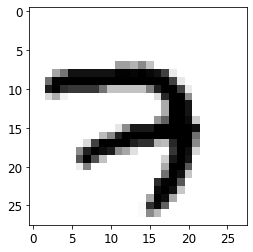

In [93]:
plt.imshow(X_train[0], cmap='binary')

In [94]:
y_train

array([7, 3, 4, ..., 5, 6, 8], dtype=uint8)

In [95]:
X_valid.shape

(5000, 28, 28)

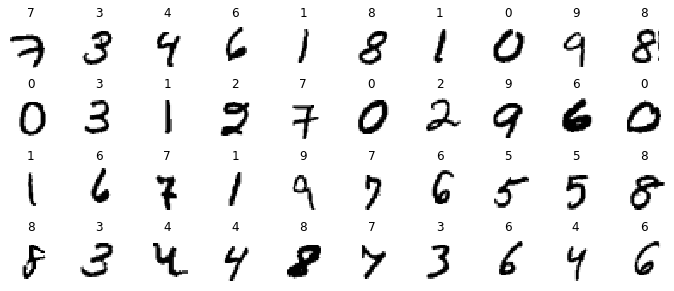

In [96]:
n_rows = 4
n_cols = 10

plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))

for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols*row + col
        plt.subplot(n_rows, n_cols, index+1)
        plt.imshow(X_train[index], cmap='binary', interpolation='nearest')
        plt.axis('off')
        plt.title(y_train[index], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)

- Now, let's build a simple dense network and find the optimal learning rate.
- We'll need a callback to grow the learning rate at each iteration. It will also record the learning rate and the loss at each iteration.

In [97]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates=[]
        self.losses=[]
        
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs['loss'])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

In [98]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [99]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

In [100]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.SGD(lr=1e-3),
             metrics=['accuracy'])
expon_lr = ExponentialLearningRate(factor=1.005)

- Now, let's train the model for just one epoch.

In [101]:
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=1, callbacks=[expon_lr])

Train on 55000 samples, validate on 5000 samples
55000/55000 [==============================] - 11s 194us/sample - loss: 62799700980007432093696.0000 - accuracy: 0.5726 - val_loss: 2.3240 - val_accuracy: 0.1100


Text(0, 0.5, 'Loss')

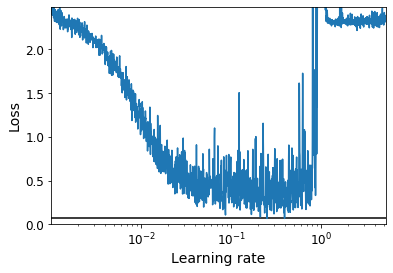

In [102]:
plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.xlabel("Learning rate")
plt.ylabel("Loss")

- From above, let's try learning rate around 2e-1.

In [103]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [104]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

In [105]:
model.compile(loss='sparse_categorical_crossentropy',
             optimizer=keras.optimizers.SGD(lr=2e-1),
             metrics=['accuracy'])

In [106]:
# run_index = 1 # increment this at every run
# run_logdir = os.path.join(os.curdir, "my_mnist_logs", "run_{:03d}".format(run_index))
# run_logdir

In [107]:
# early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
# checkpoint_cb = keras.callbacks.ModelCheckpoint("my_mnist_model.h5", save_best_only=True)
# tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

# history = model.fit(X_train, y_train, epochs=100,
#                     validation_data=(X_valid, y_valid),
#                     callbacks=[early_stopping_cb, checkpoint_cb, tensorboard_cb])

In [108]:
# model = keras.models.load_model('my_mnist_model.h5')
# model.evaluate(X_test, y_test)